## Sensor Component Fault Detection

    > Problem Statement: 
        
        - The Air Pressure System which generates pressurized air that ar utilized in various functions in a truck, such as bracking and gear changes. The dataset positive class corresponds to component failure in APS system, whereas, the negative class of the dataset corresponds to the component failure for non APS system.
        
        - The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false prediction. 

        - Cost1 = 10 and Cost2 = 500 
             Total_Cost = Cost1*NO_INSTANCES + Cost2*NO_INSTANCES

        - We have to reduce false negative and positives. 
        
***More importantly we have to reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.***



In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

## Read Data 

In [2]:
df = pd.read_csv(r'C:/Users/nikhi/project00/aps_failure_training_set.csv', na_values="na")
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB


In [4]:
# Check the data distribution
df.shape

(60000, 171)

In [5]:
df['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

In [6]:
cat_columns = [column for column in df.columns if df[column].dtype == 'O']
num_columns = [column for column in df.columns if df[column].dtype != 'O']

print("There are {} catgorical features".format(len(cat_columns)), cat_columns)
print("There are {} numerical features".format(len(num_columns)), num_columns)

There are 1 catgorical features ['class']
There are 170 numerical features ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_00

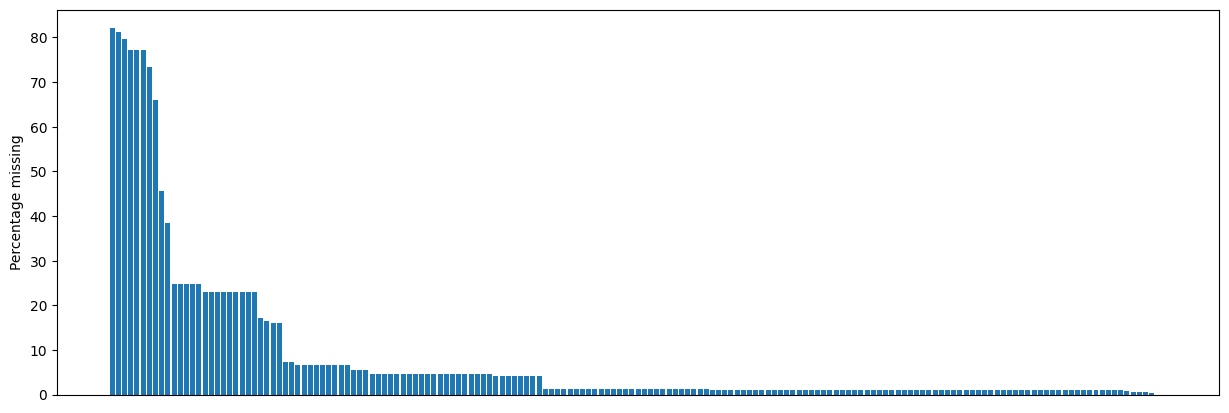

In [7]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [8]:
## Dropping columns which has more than 70% of missing values
dropcols = missing[missing[0]>70]
dropcols


,0
br_000,82.106667
bq_000,81.203333
bp_000,79.566667
bo_000,77.221667
ab_000,77.215000
cr_000,77.215000
bn_000,73.348333


In [9]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()
# print(total_cells)
# print(total_missing)
print(f"Percentage of total missing cells in the data (Before Dropping Data): {round((total_missing/total_cells)*100,2)}%")

Percentage of total missing cells in the data (Before Dropping Data): 8.28%


In [10]:
drop_columns = missing[missing[0]>60]
df.drop(list(drop_columns.index), axis=1, inplace=True)

In [11]:
df.shape

(60000, 163)

In [12]:
df['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

In [13]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()
# print(total_cells)
# print(total_missing)
print(f"Percentage of total missing cells in the data (After Dropping Data): {round((total_missing/total_cells)*100,2)}%")

Percentage of total missing cells in the data (After Dropping Data): 4.93%


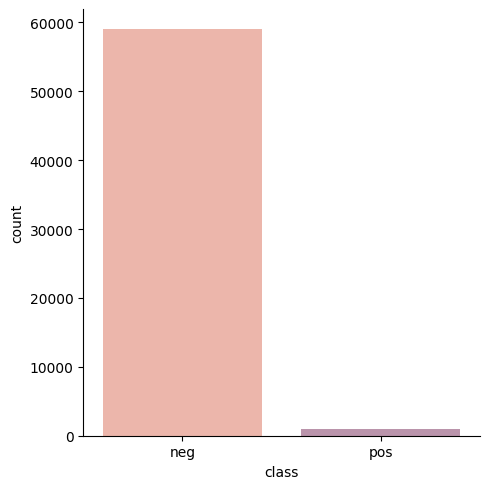

In [14]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]

sns.catplot(data=df, x='class', kind="count", palette='rocket_r', alpha=0.5)

***Based on the observations, the target class is is very unbalanced***
If the Imbalanced data is not treated beforehand, then this will degrade the performace of the classifier model.

How to handle Imbalanced data? 
>     Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this:
    >           1. Undersampling and 2. Oversampling
          We use oversampling methods as undersampling tends to remove instances from data that may be carrying important information.

     - SMOTE - Synthetic Minority Oversampling Technique where synthetic samples are generated for minority class.
     - Hybridization technique involves combining both undersampling and oversampling. This is done to optimize the performance of the classifier models for the samples created as part of these techniques.
     - It only duplicatesthe data and it won't add any new information.

## Functions for Model Traning and Evaluation 

In [15]:
def evaluate_clf(true, predicted):
    """
    This Funciton takes in true values and predicted values 
    Returns: Accuracy, F1 score , Precision, Recall, ROC_AUC Score
    """
    # Calculate Accuracy
    acc = accuracy_score(true, predicted) 
    # Calculate F1-score
    f1 = f1_score(true, predicted) 
    # Calculate Precision
    precision = precision_score(true, predicted) 
    # Calculate Recall
    recall = recall_score(true, predicted)  
    #Calculate Roc
    roc_auc = roc_auc_score(true, predicted) 
    return acc, f1 , precision, recall, roc_auc

In [16]:
# Create a cost of model as per data description
def total_cost(y_true, y_pred):
    """
    This function takes y_true, y_predicted,
    computes the total cost due to misclassification
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    cost = 10*fp + 500*fn
    return cost

In [17]:
def evaluate_models(X,y, models):
    """
    This function takes in X and y, models dictionary as input 
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: DataFrame which contains report of all models metrics with cost
    """
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
    cost_list = []
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train,y_train)

        # Make Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, \
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train,y_train_pred)
        train_cost = total_cost(y_train,y_train_pred)

        # Testing set performance
        model_test_accuracy, model_test_f1, model_test_precision, \
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test,y_test_pred)
        test_cost = total_cost(y_test,y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report


## Visual Representation of Independent Features 

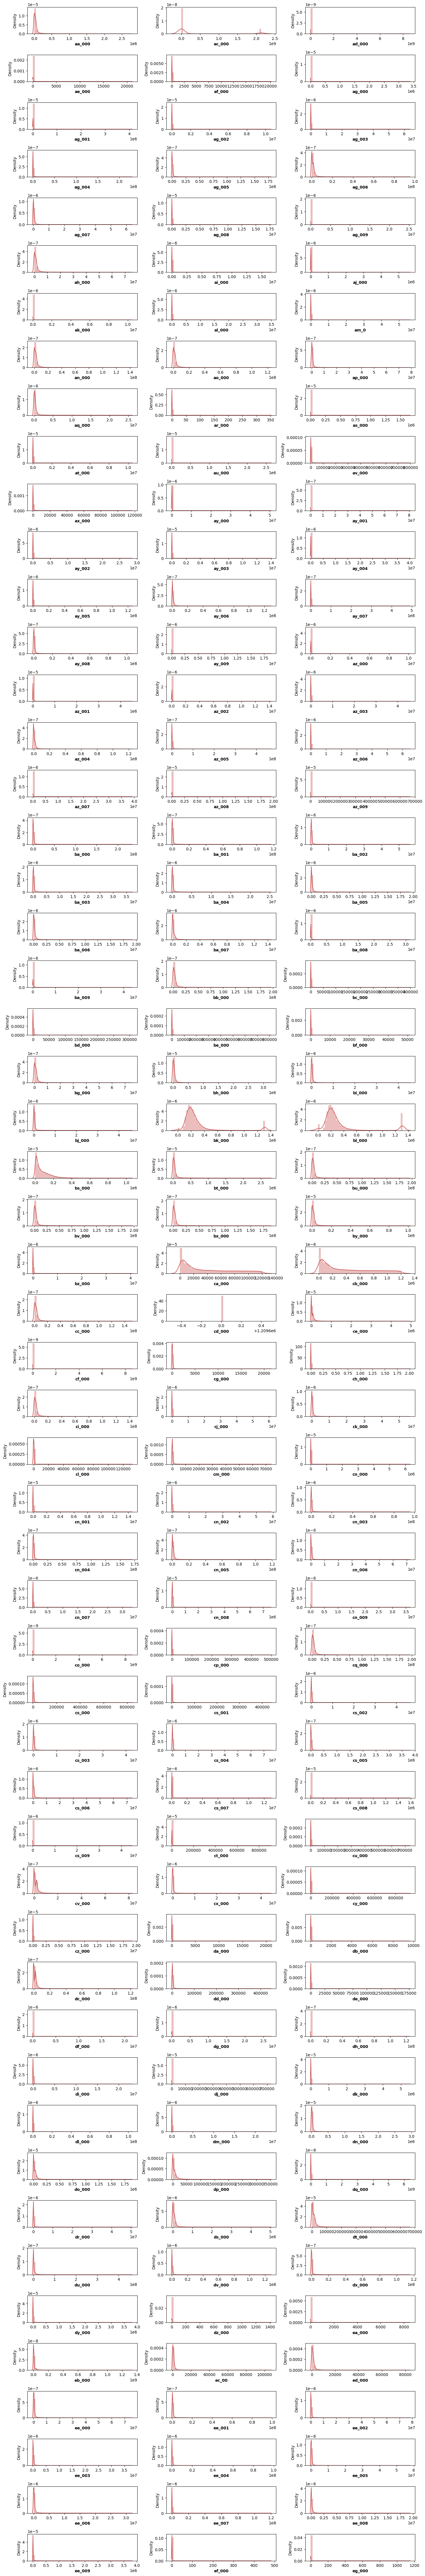

In [26]:
num_columns = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(num_columns):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

- As per the plots, most of the features are not nomrally distributed.
- Transformation of data is not important as this is a classification problem.
- Interpretation of each column is not required.

## Evaluate Model in Different Experiments 

In [18]:
X = df.drop('class', axis=1)
y = df['class']

In [19]:
# Manually Encoding Target Variable 
y = y.replace({'pos':1,'neg':0})

## Experiment 1: KNN Imputer for Null Values 
*Why Robust and not Standard Scaler?*
    
    - Scaling the data using Robust Scaler since most of the independent variables are not normally distributed we cannot use standardscaler

*Why Robust and not MinMax?*
    
    - Because most of the features has outliers. So Minmax will scale data according to max value which is a otulier.
    - This scaler removes the median and scales the according to the quantile range. The IQR is th range between the 1st quartile and 3rd quartile.

In [29]:
# Fit with robust scaler for KNN Imputer best K-selection experiment
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

__*Why KNN Imputer?*__

    - KNN Imputer by scikit-learn is a widely used method to impute the missing values. It is widely being observed as replacement for traditional imputation techniques.
    - KNN Imputer helps to impute the missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix. 
    - Here we iterates through different K values and get accuracy and choose K values.

In [30]:
results = []
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[("i", KNNImputer(n_neighbors=int(s))),("m",LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy',cv=2, n_jobs=-1)
    results.append(scores)
    print("n_neighbors = %s || accuracy (%.4f)" % (s, mean(scores))) 

n_neighbors = 1 || accuracy (0.7764)
n_neighbors = 3 || accuracy (0.7875)
n_neighbors = 5 || accuracy (0.7637)
n_neighbors = 7 || accuracy (0.7620)
n_neighbors = 9 || accuracy (0.7337)


__*We can observe n_neighbors=3 able to produce highest accuracy*__

## Pipeline for KNN Imputer

In [31]:
num_features = X.select_dtypes(exclude='object').columns

knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('Robust Scaler', RobustScaler())
])

X_knn = knn_pipeline.fit_transform(X)

## Handling Imbalanced Data 

__SMOTE+TOMEK__ is a hybrid technique that aims to clean ovelaping data for 
each of the classes distributed in sample space.

    - This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class 

    - To add new data of minority class 
    
    1. Choose random data from minority class.
    2. Calculate the the distance between the random data and its k nearest neighbors.
    3. Multiply the difference with a random number between 0 to 1, then add the result to the minority class as synthetic sample.
    4. Repeat step 2-3 until desired proportion of minority class is met.

    - To remove the tomek links of the minority class

    1. Choose the random data from majority class.
    2. If the random data's nearest neighboor is the data from the minority class (i.e. create the Tomek link), then remove Tomek Link.

    - This method instead of adding duplicate data it synthesis the new data based on the already present data available classes. hence we choosee this imputation techniwuee for this problem statement. 



In [33]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

X_res, y_res = smt.fit_resample(X_knn,y)

In [25]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [44]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9937
- F1 score: 0.9937
- Precision: 0.9901
- Recall: 0.9974
- Roc Auc Score: 0.9938
- COST: 26930.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9885
- F1 score: 0.9885
- Precision: 0.9843
- Recall: 0.9929
- Roc Auc Score: 0.9886
- COST: 72070.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9840
- F1 score: 0.9841
- Precision: 0.9811
- Recall: 0.9871
- Roc Auc Score: 0.9840
- COST: 263040.
----------------------------------
Model performance for Test set
- Accuracy: 0.9831
- F1 score: 0.9831
- Precision: 0.9774
- Recall: 0.9888
- Roc Auc

ravel()?

In [45]:
report_knn

,Model Name,Cost
5,XGBClassifier,8030
6,CatBoosting Classifier,17370
0,Random Forest,26930
1,Decision Tree,72070
4,K-Neighbors Classifier,112230
2,Gradient Boosting,112910
7,AdaBoost Classifier,233720
3,Logistic Regression,997660


__Insights__

    - For Experiment 1: KNN Imputer has XGBoost Classifier as the best model.

## Experiment 2 - Simple Imputer with Median Strategy
     - Simple Imputer is a class in sklearn.impute module that can be used to replace missing values in a datasetusing variety of ominput strategies.
     - Here we use a Simple Imputer to impute multiple columns at once by passing a list of column names.

In [20]:
num_features = X.select_dtypes(exclude='object').columns

# Simple Imputer with Median Strategy
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('robustscaler', RobustScaler())
])

In [21]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [24]:
# Resampling the minority Class.
smt = SMOTETomek(random_state=42, sampling_strategy='minority')
# Fit the model on the data
X_res, y_res = smt.fit_resample(X_median, y)

In [26]:
# Training the models 
report_median = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9941
- F1 score: 0.9941
- Precision: 0.9908
- Recall: 0.9974
- Roc Auc Score: 0.9941
- COST: 27290.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9888
- F1 score: 0.9888
- Precision: 0.9846
- Recall: 0.9929
- Roc Auc Score: 0.9888
- COST: 71490.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9831
- F1 score: 0.9832
- Precision: 0.9808
- Recall: 0.9855
- Roc Auc Score: 0.9831
- COST: 294620.
----------------------------------
Model performance for Test set
- Accuracy: 0.9816
- F1 score: 0.9816
- Precision: 0.9783
- Recall: 0.9849
- Roc Auc

In [27]:
report_median

,Model Name,Cost
5,XGBClassifier,11790
6,CatBoosting Classifier,18550
0,Random Forest,27290
1,Decision Tree,71490
4,K-Neighbors Classifier,95140
2,Gradient Boosting,150210
7,AdaBoost Classifier,271040
3,Logistic Regression,277870


__Conclusion: In Experiment 2, XGB Classifier with Simple Imputer; Median Strategy has the lowest cost__

## Experiment 3- MICE for Imputing Null Values

MICE stands for Multivariate Imputation By Chained Equations Algorithm, this technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing values.

In [28]:
import miceforest as mf
X_mice = X.copy()
kernel = mf.ImputationKernel(
    X_mice,
    save_all_iterations=True,
    random_state=42
)

In [29]:
X_mice = kernel.complete_data()

In [30]:
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])
X_mice = mice_pipeline.fit_transform(X_mice)

In [31]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [32]:
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9935
- F1 score: 0.9935
- Precision: 0.9898
- Recall: 0.9972
- Roc Auc Score: 0.9935
- COST: 28980.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9876
- F1 score: 0.9876
- Precision: 0.9842
- Recall: 0.9910
- Roc Auc Score: 0.9876
- COST: 90080.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9849
- F1 score: 0.9850
- Precision: 0.9814
- Recall: 0.9885
- Roc Auc Score: 0.9849
- COST: 234390.
----------------------------------
Model performance for Test set
- Accuracy: 0.9831
- F1 score: 0.9831
- Precision: 0.9787
- Recall: 0.9875
- Roc A

In [33]:
report_mice

,Model Name,Cost
5,XGBClassifier,8560
6,CatBoosting Classifier,17800
0,Random Forest,28980
1,Decision Tree,90080
4,K-Neighbors Classifier,111000
2,Gradient Boosting,124650
7,AdaBoost Classifier,256310
3,Logistic Regression,560360


__Conclusion: XGB CLassifier with Simple Imputer (Strategy: Constant)__

## Experiment 4 - Simple Imputer with Constant Strategy
    
    - Another strategy which can be used is replacing the missing values with fixed constant value.
    
    - To do this, specify "constant" for strategy and specify the fill value using the fill_value parameter. 

In [34]:
constant_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='constant', fill_value=0)),
    ("robust scaler", RobustScaler())
])

In [35]:
X_const = constant_pipeline.fit_transform(X)

In [36]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [37]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9944
- F1 score: 0.9944
- Precision: 0.9912
- Recall: 0.9977
- Roc Auc Score: 0.9944
- COST: 23720.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9884
- F1 score: 0.9884
- Precision: 0.9841
- Recall: 0.9928
- Roc Auc Score: 0.9884
- COST: 73110.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9832
- F1 score: 0.9833
- Precision: 0.9799
- Recall: 0.9868
- Roc Auc Score: 0.9832
- COST: 268990.
----------------------------------
Model performance for Test set
- Accuracy: 0.9815
- F1 score: 0.9815
- Precision: 0.9779
- Recall: 0.9852
- Roc Auc

In [38]:
report_const

,Model Name,Cost
5,XGBClassifier,11000
6,CatBoosting Classifier,16240
0,Random Forest,23720
1,Decision Tree,73110
4,K-Neighbors Classifier,96090
2,Gradient Boosting,147310
7,AdaBoost Classifier,268230
3,Logistic Regression,273960


## Experiment 5 - Simple Imputer Strategy- Mean 

In [41]:
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('robustscaler', RobustScaler())
])

In [42]:
X_mean = mean_pipeline.fit_transform(X)

In [43]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

In [44]:
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 10.
----------------------------------
Model performance for Test set
- Accuracy: 0.9939
- F1 score: 0.9939
- Precision: 0.9907
- Recall: 0.9971
- Roc Auc Score: 0.9939
- COST: 30310.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9877
- F1 score: 0.9877
- Precision: 0.9840
- Recall: 0.9914
- Roc Auc Score: 0.9877
- COST: 86610.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9868
- F1 score: 0.9869
- Precision: 0.9833
- Recall: 0.9905
- Roc Auc Score: 0.9868
- COST: 194160.
----------------------------------
Model performance for Test set
- Accuracy: 0.9839
- F1 score: 0.9838
- Precision: 0.9797
- Recall: 0.9880
- Roc Au

In [45]:
report_mean

,Model Name,Cost
5,XGBClassifier,13930
6,CatBoosting Classifier,23330
0,Random Forest,30310
1,Decision Tree,86610
4,K-Neighbors Classifier,107440
2,Gradient Boosting,119950
7,AdaBoost Classifier,255620
3,Logistic Regression,985740
